In [3]:
def check_gpu(verbose = 1):
    import os

    if verbose:
        print ('\n0. Nvidia Hardware (lspci | grep -i nvidia) : ', [each for each in os.popen('lspci | grep -i nvidia')])
        print ('0. Nvidia Driver (cat /proc/driver/nvidia/version) : ', [each for each in os.popen('cat /proc/driver/nvidia/version')][0])
        print ('0. Nvidia Driver (ls /usr/lib | grep nvidia-) : ', [each for each in os.popen('ls /usr/lib | grep nvidia-')])
        print ('0. Nvidia Driver : (dpkg --get-selections | grep nvidia) : ')
        for each in os.popen('dpkg --get-selections | grep nvidia'):
            print (each)
        print ('\n0. Envs  : CUDA_HOME', os.environ['CUDA_HOME'])
        print ('0. Envs  : CUDA_ROOT',os.environ['CUDA_ROOT'])
        print ('0. Envs  : LD_LIBRARY_PATH:', os.environ['LD_LIBRARY_PATH'])
        print ('0. Envs  : PATH (containing cuda)', [each for each in os.environ['PATH'].split(':') if each.find('cuda') > -1])
        print ('0. CUDnn :', [each.replace('\n', '') for each in os.popen('find /usr/local/cuda-8.0/ -name *dnn*')])

    from keras import backend as K
    K.clear_session()

    print ('\n0. Keras backend:', K.backend())
    if K.backend() == 'tensorflow':
        from tensorflow.python.client import device_lib
        devices = device_lib.list_local_devices()
        for device in devices:
            print ('0. TensorFlow Devices:', str(device.name).replace('\n',''))
        print ('\n')

        return 1 if len(devices) > 1 else 0

    else:
        return 0

In [5]:
if __name__ == "__main__":
    import learned_amp_problems as problems
    import learned_amp_train as train_graphs
    import learned_amp_networks as networks
    
    import numpy as np
    import os

    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # BE QUIET!!!!
    import tensorflow as tf

    np.random.seed(1) # numpy is good about making repeatable output
    
    TRAIN = 1
    
    if (check_gpu(verbose=0)):
        if train:
            prob = problems.images_problem('data/processed_data/')
            print ('1. Problem created :', prob.name)
            print ('A:', prob.A.shape)
            print ('X:', prob.xval.shape, ' prob.x_:', prob.x_)
            print ('y:', prob.yval.shape, ' prob.y_:', prob.y_)
            print ('Samples for training:', prob.xval.shape[1])

            ## build a LAMP network to solve the problem and get the intermediate results so we can greedily extend and then refine(fine-tune)
            T = 3
            layers = networks.build_LAMP(prob,T=T,shrink='bg',untied=False)
            print ('\n2. Network Built : LAMP with ', T, ' layers')
            for i, layer in enumerate(layers):
                print (i, ' : Name: ', layer[0], ' Output:', layer[1], ' Vars:', layer[2])

            # plan the learning
            print ('\n3. Turning layers into training stages')
            # training_stages = train.setup_training(layers,prob,trinit=1e-3,refinements=(.5,.1,.01) )
            training_stages = train_graphs.setup_training(layers,prob,trinit=1e-3,refinements=(.5,.01) )

            ## do the learning (takes a while)
            #maxit = 1000 (since the y, A, x variables are very heavy even for a GPU)
            savefile = 'amp_models/LAMP_' + prob.name + '.npz'
            # sess = train.do_training(training_stages,prob,savefile, maxit = 100)


0. Keras backend: tensorflow
0. TensorFlow Devices: /cpu:0
0. TensorFlow Devices: /gpu:0


Processed Data: y: (2000, 1024)  A: (1024, 4096)  X: (2000, 4096)
1. Problem created : 2D_Images
A: (1024, 4096)
X: (4096, 2000)  prob.x_: Tensor("x:0", shape=(4096, ?), dtype=float32)
y: (1024, 2000)  prob.y_: Tensor("y:0", shape=(1024, ?), dtype=float32)
Samples for training: 2000

2. Original theta: (1, 2.1972245773362196)
2. Eta function returns: xhat Tensor("truediv_4:0", shape=(4096, ?), dtype=float32)  dxdr_ Tensor("Mean:0", shape=(?,), dtype=float32)

2. Network Built : LAMP with  3  layers
0  : Name:  Linear  Output: Tensor("MatMul:0", shape=(4096, ?), dtype=float32)  Vars: None
1  : Name:  LAMP-bg T=1  Output: Tensor("truediv_4:0", shape=(4096, ?), dtype=float32)  Vars: (<tf.Variable 'theta_0:0' shape=(2,) dtype=float32_ref>,)
2  : Name:  LAMP-bg non-linear T=2  Output: Tensor("truediv_10:0", shape=(4096, ?), dtype=float32)  Vars: (<tf.Variable 'theta_1:0' shape=(2,) dtype=float32_ref>

Data:
A: (1024, 4096)
y: (2000, 1024) 

y_rand: (1024, 1) 

restoring theta_0:0
restoring B_0:0
restoring theta_2:0
restoring theta_1:0


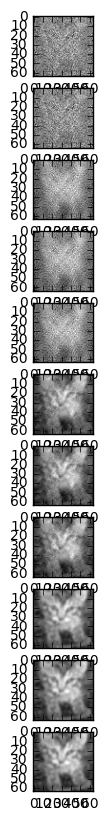

In [14]:
# import sys; sys.exit(1)
import joblib
import scipy.fftpack as spfft
import matplotlib.pyplot as plt

%matplotlib inline

""" TRANSFORM CLASSES """
class DCT():
    def dct2(self, x):
        return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

    def idct2(self, x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

inverse_dct = lambda x: DCT().idct2(x)

""" GET DATA """
url_processed_folder = 'data/processed_data/'
url_filename_A = url_processed_folder + 'A.gz'
with open(url_filename_A, 'rb') as handle:
    A = joblib.load(handle)
    A = A.astype(np.float32)

url_filename_y = url_processed_folder + 'y.gz'
with open(url_filename_y, 'rb') as handle:
    y = joblib.load(handle)
    rand_idx = np.random.randint(0, len(y))
    y_rand = y[rand_idx]
    y_rand = y_rand.reshape(y_rand.shape[0], 1)

print ('Data:')
print ('A:', A.shape)
print ('y:', y.shape, '\n')
print ('y_rand:', y_rand.shape, '\n')
    
""" LOAD MODEL """
sess = tf.Session()
sess.run(tf.global_variables_initializer())
state = train_graphs.load_trainable_vars(sess,savefile)

f, axarr = plt.subplots(len(training_stages), figsize=(10,10))
for i, (name,xhat_,loss_,nmse_,train_,var_list) in enumerate(training_stages):
    xhat_ = sess.run(xhat_,feed_dict={prob.y_:y_rand, prob.A_:A})
    xhat_recon = inverse_dct(xhat_.reshape(64,64))
    axarr[i].imshow(xhat_recon, cmap = 'gray')
    